In [1]:
from src.functions import *

In [2]:
plt.rcParams.update(
    {
        "xtick.direction": "in",
        "ytick.direction": "out",
        "ytick.right": False,
        "xtick.top": False,
        "ytick.left": True,
        "xtick.bottom": False,
        "figure.facecolor": "1",
        "savefig.facecolor": "1",
        "savefig.dpi": 600,
        "figure.dpi": 600,
        "savefig.bbox": "tight",
        "font.size": 7,
        "font.family": "serif",
        "lines.markersize": 4,
        "lines.linewidth": 1,
        'axes.axisbelow' : True
    }
)

In [178]:
data = load_from_json(f'data/delta_vs_t.json')
delta_quantum_arr = np.asarray(data['delta'])[:,1:]
qubits_range = data['qubits_range']
time_range = data['time_range'][1:]
T = data['T']
gammas = data['gammas']

In [179]:
delta_quantum_arr_avg = np.mean(delta_quantum_arr, axis=2)
delta_quantum_arr_std = np.std(delta_quantum_arr, axis=2, ddof=1) / np.sqrt(len(delta_quantum_arr[0,0]))

In [180]:
data_short_times = load_from_json(f'data/delta_vs_t_short_times.json')
delta_short_times_quantum_arr = np.asarray(data_short_times['delta'])[:,1:]
time_range_short_times = data_short_times['time_range'][1:]

In [181]:
delta_short_times_quantum_arr_avg = np.mean(delta_short_times_quantum_arr, axis=2)
delta_short_times_quantum_arr_std = np.std(delta_short_times_quantum_arr, axis=2, ddof=1) / np.sqrt(len(delta_short_times_quantum_arr[0,0]))

## $\delta$ vs $t$

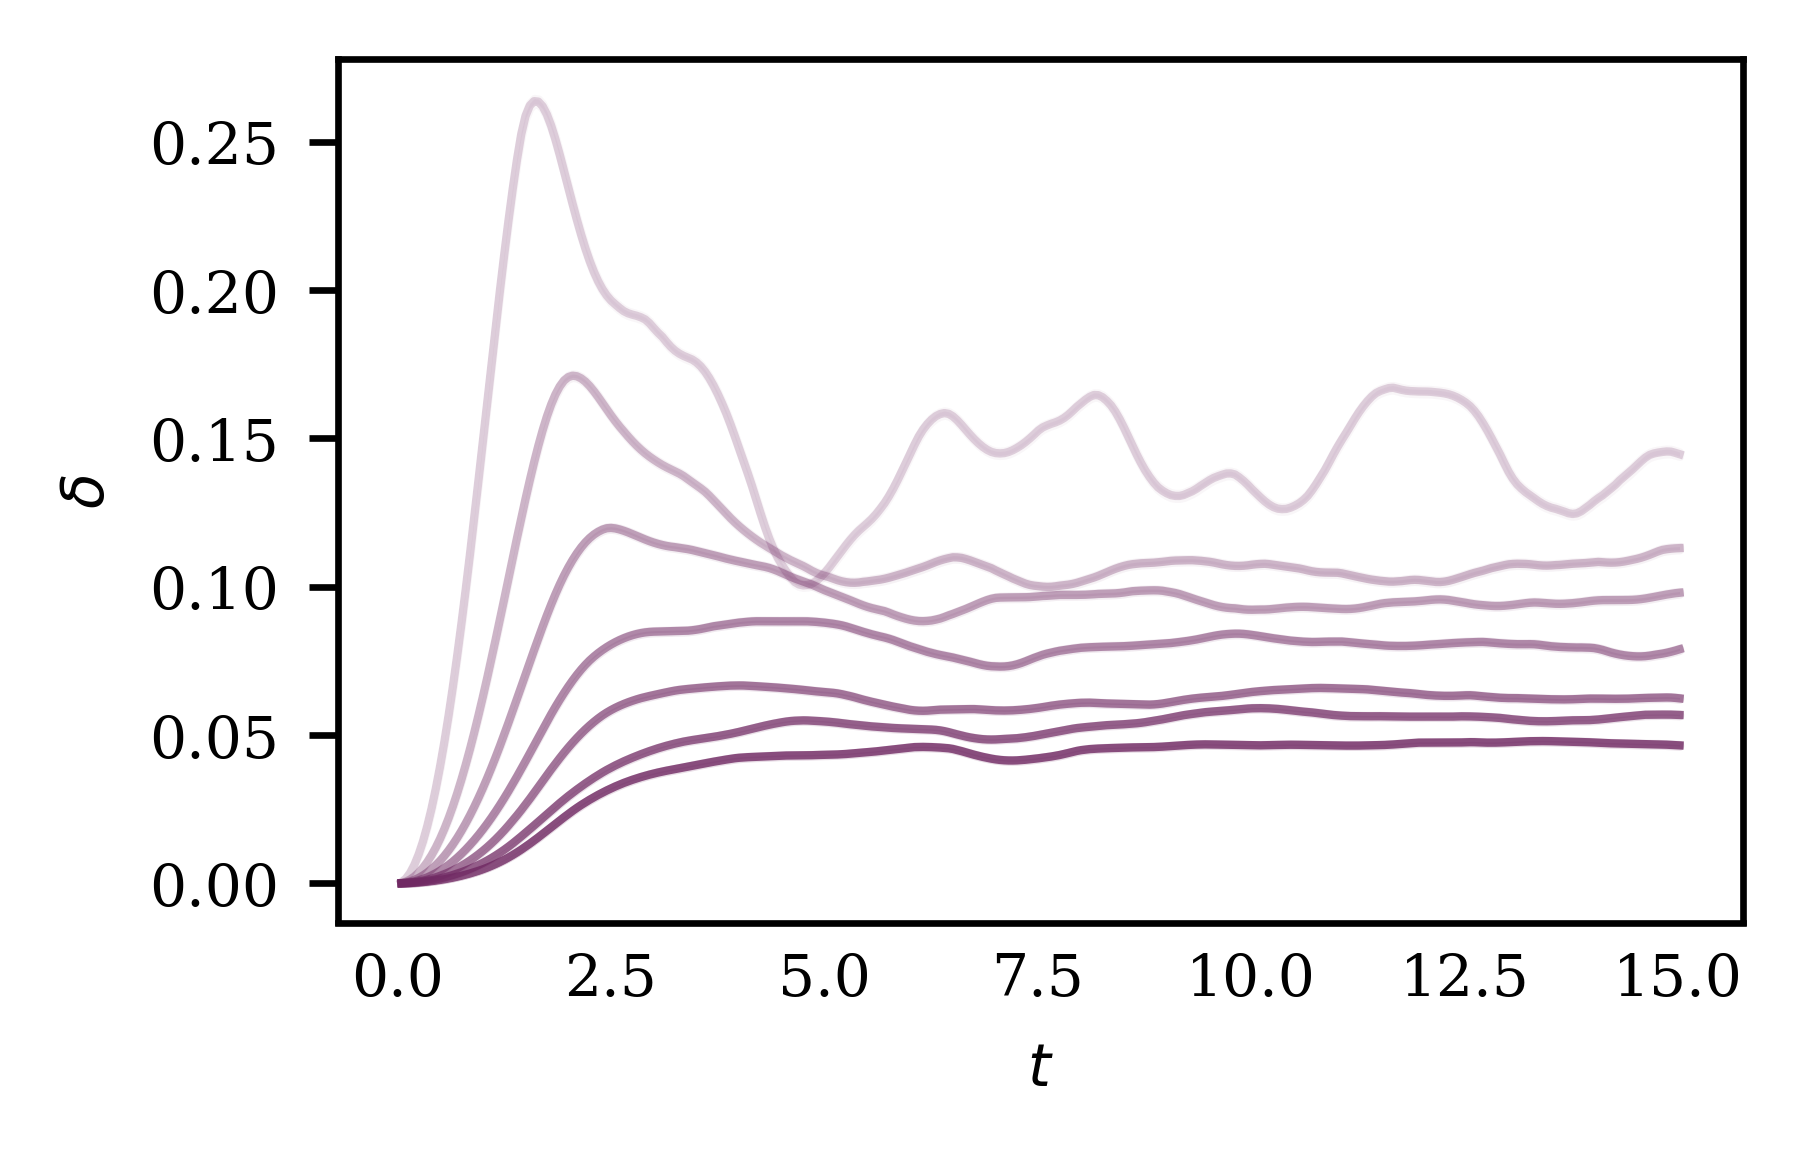

In [182]:
fig = plt.figure(figsize=(figure_size_x/2, figure_size_y/2))

for n_id, n in enumerate(qubits_range[:]):
    plt.plot(time_range[:300], 
            delta_quantum_arr_avg[n_id][:300],
            color=colors['purple'],
            label=f'n={n}',
            alpha=(0.2 + 0.1*n_id))
    plt.fill_between(time_range[:300], delta_quantum_arr_avg[n_id][:300]-delta_quantum_arr_std[n_id][:300]/10, delta_quantum_arr_avg[n_id][:300]+delta_quantum_arr_std[n_id][:300]/10, color=colors["purple"], alpha=(0.2 + 0.1*n_id)*0.2)

plt.xlabel('$t$')
plt.ylabel('$\delta$')
# plt.legend()
plt.show()
fig.tight_layout()

fig.savefig(projectdir+f'figures/delta_vs_t')

## $\delta$ / $t$

In [183]:
arg_opt = np.asarray([np.argmin(time_range_short_times / delta_short_times_quantum_arr_avg[n_id]) for n_id in range(len(qubits_range))])
t_opt_arr = np.asarray([time_range_short_times[i] for i in arg_opt])
delta_opt_arr = np.asarray([delta_short_times_quantum_arr_avg[i_id][i] for i_id, i in enumerate(arg_opt)])

In [184]:
len(delta_short_times_quantum_arr_avg[0])

999

In [185]:
t_err = time_range_short_times[1] - time_range_short_times[0]
t_err_arr = np.ones_like(time_range_short_times) * t_err

delta_err_arr = delta_short_times_quantum_arr_std
delta_over_t_arr = np.asarray([delta_short_times_quantum_arr_avg[n_id] / time_range_short_times for n_id in range(len(qubits_range))])
delta_over_t_opt_arr = delta_opt_arr / t_opt_arr
delta_over_t_err_arr = np.asarray([delta_over_t_arr[i] * np.sqrt((delta_err_arr[i] / delta_short_times_quantum_arr_avg[i])**2 + (t_err_arr / time_range_short_times)**2) for i in range(len(qubits_range))])
delta_over_t_opt_err_arr = np.asarray([delta_over_t_err_arr[i_id][i] for i_id, i in enumerate(arg_opt)])

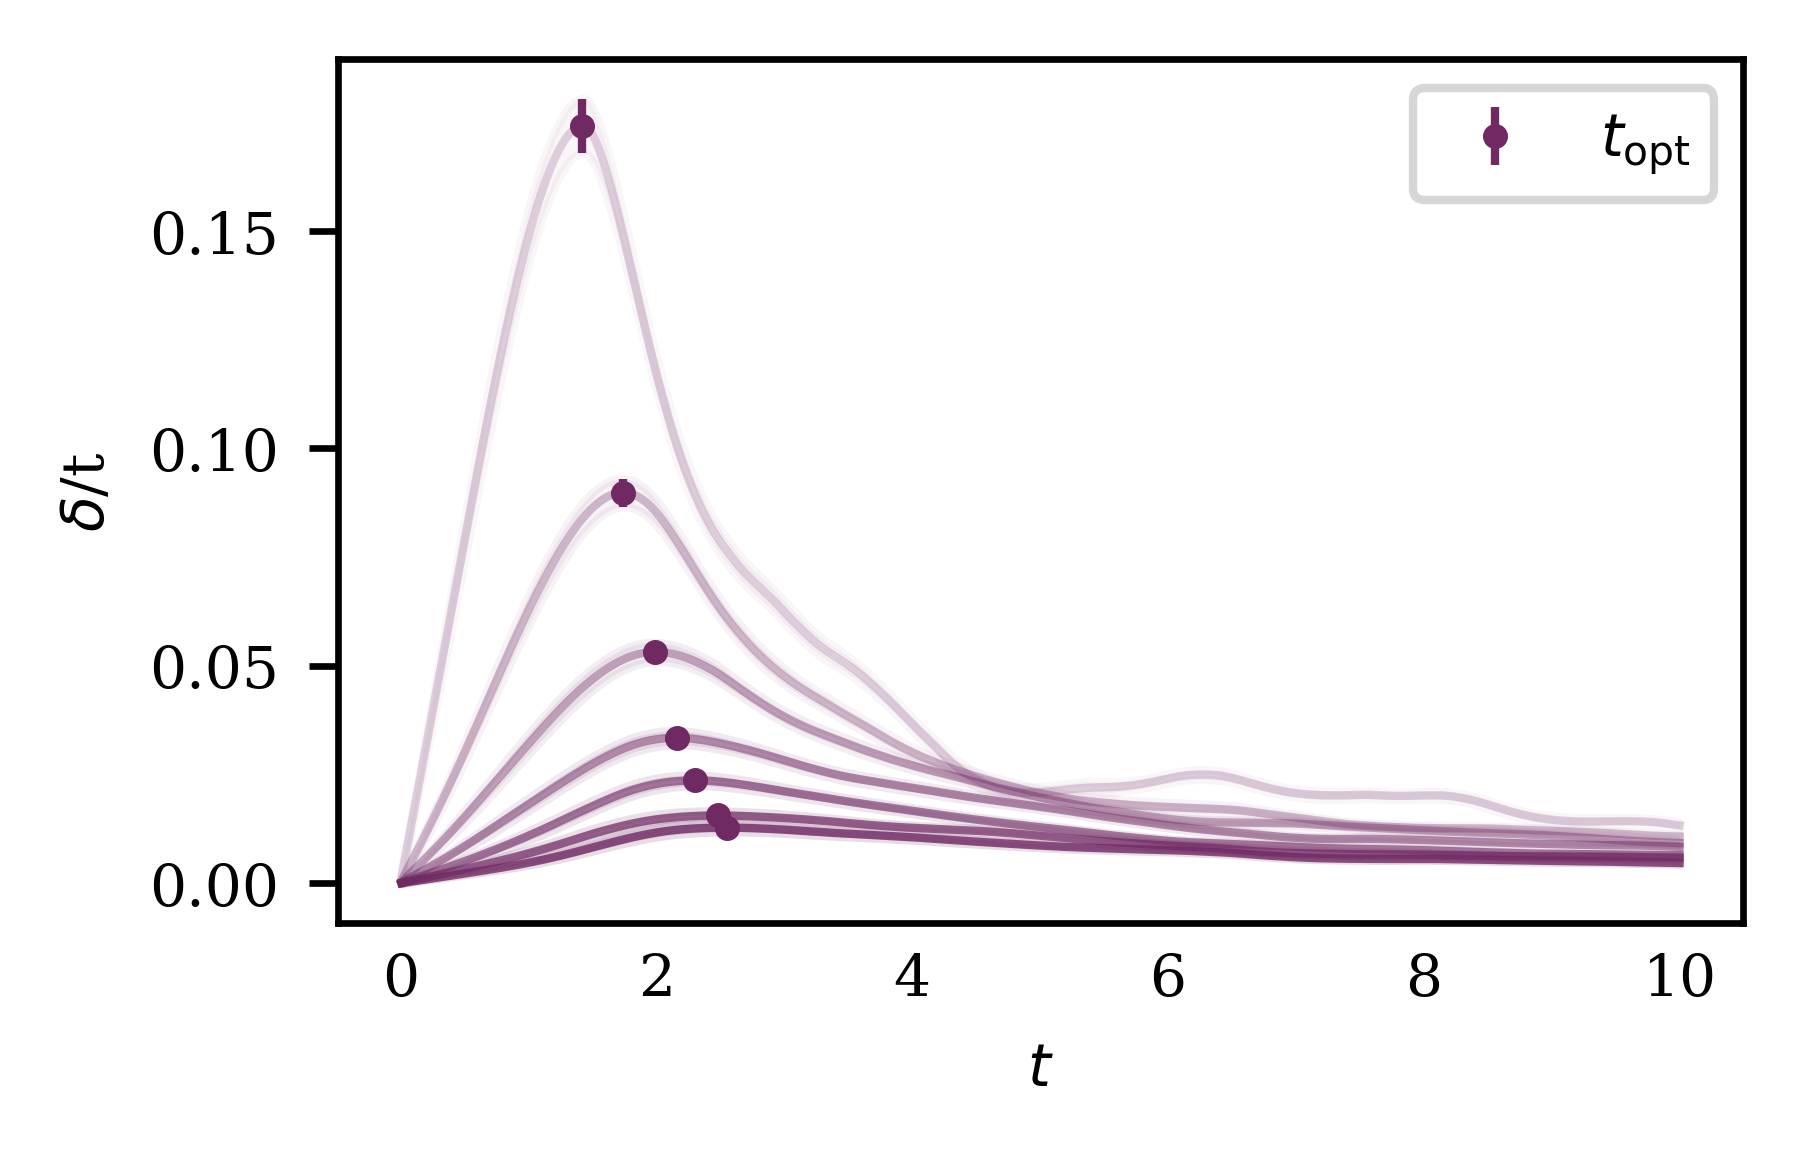

In [186]:
fig = plt.figure(figsize=(figure_size_x/2, figure_size_y/2))

for n_id, n in enumerate(qubits_range):
    plt.plot(time_range_short_times, 
             delta_over_t_arr[n_id],
             color=colors['purple'],
         #     label=f'n={n}',
             alpha=(0.2 + 0.1*n_id))
    plt.fill_between(time_range_short_times, 
                     delta_over_t_arr[n_id]-delta_over_t_err_arr[n_id], 
                     delta_over_t_arr[n_id]+delta_over_t_err_arr[n_id],
                     color=colors['purple'],
                     alpha=(0.2 + 0.1*n_id)*0.2)

plt.errorbar(t_opt_arr, 
             delta_over_t_opt_arr, 
             delta_over_t_opt_err_arr,
             fmt='.', 
             color=colors['purple'],
             ms=4,
            #  capsize=2,
             label='$t_{\mathrm{opt}}$')

plt.xlabel('$t$')
plt.ylabel('$\delta$/t')
plt.legend()
plt.show()
fig.tight_layout()

fig.savefig(projectdir+f'figures/delta_over_t_vs_t')

## Finding optimal $t$

In [187]:
delta_over_t_ub_arr = np.asarray([delta_over_t_arr[n_id]+delta_over_t_err_arr[n_id] for n_id, n in enumerate(qubits_range)])
ub_shifted = np.asarray([delta_over_t_ub_arr[n_id]-delta_over_t_opt_arr[n_id] for n_id, n in enumerate(qubits_range)])

In [188]:
indices_greater_than_zero = [np.where(ub_shifted[n_id] > 0)[0] for n_id, n in enumerate(qubits_range)]

In [189]:
id_lb = [indices_greater_than_zero[n_id][0] for n_id, n in enumerate(qubits_range)]
id_ub = [indices_greater_than_zero[n_id][-1] for n_id, n in enumerate(qubits_range)]
t_opt_err_arr = [time_range_short_times[id_ub[n_id]] - time_range_short_times[id_lb[n_id]] for n_id, n in enumerate(qubits_range)]

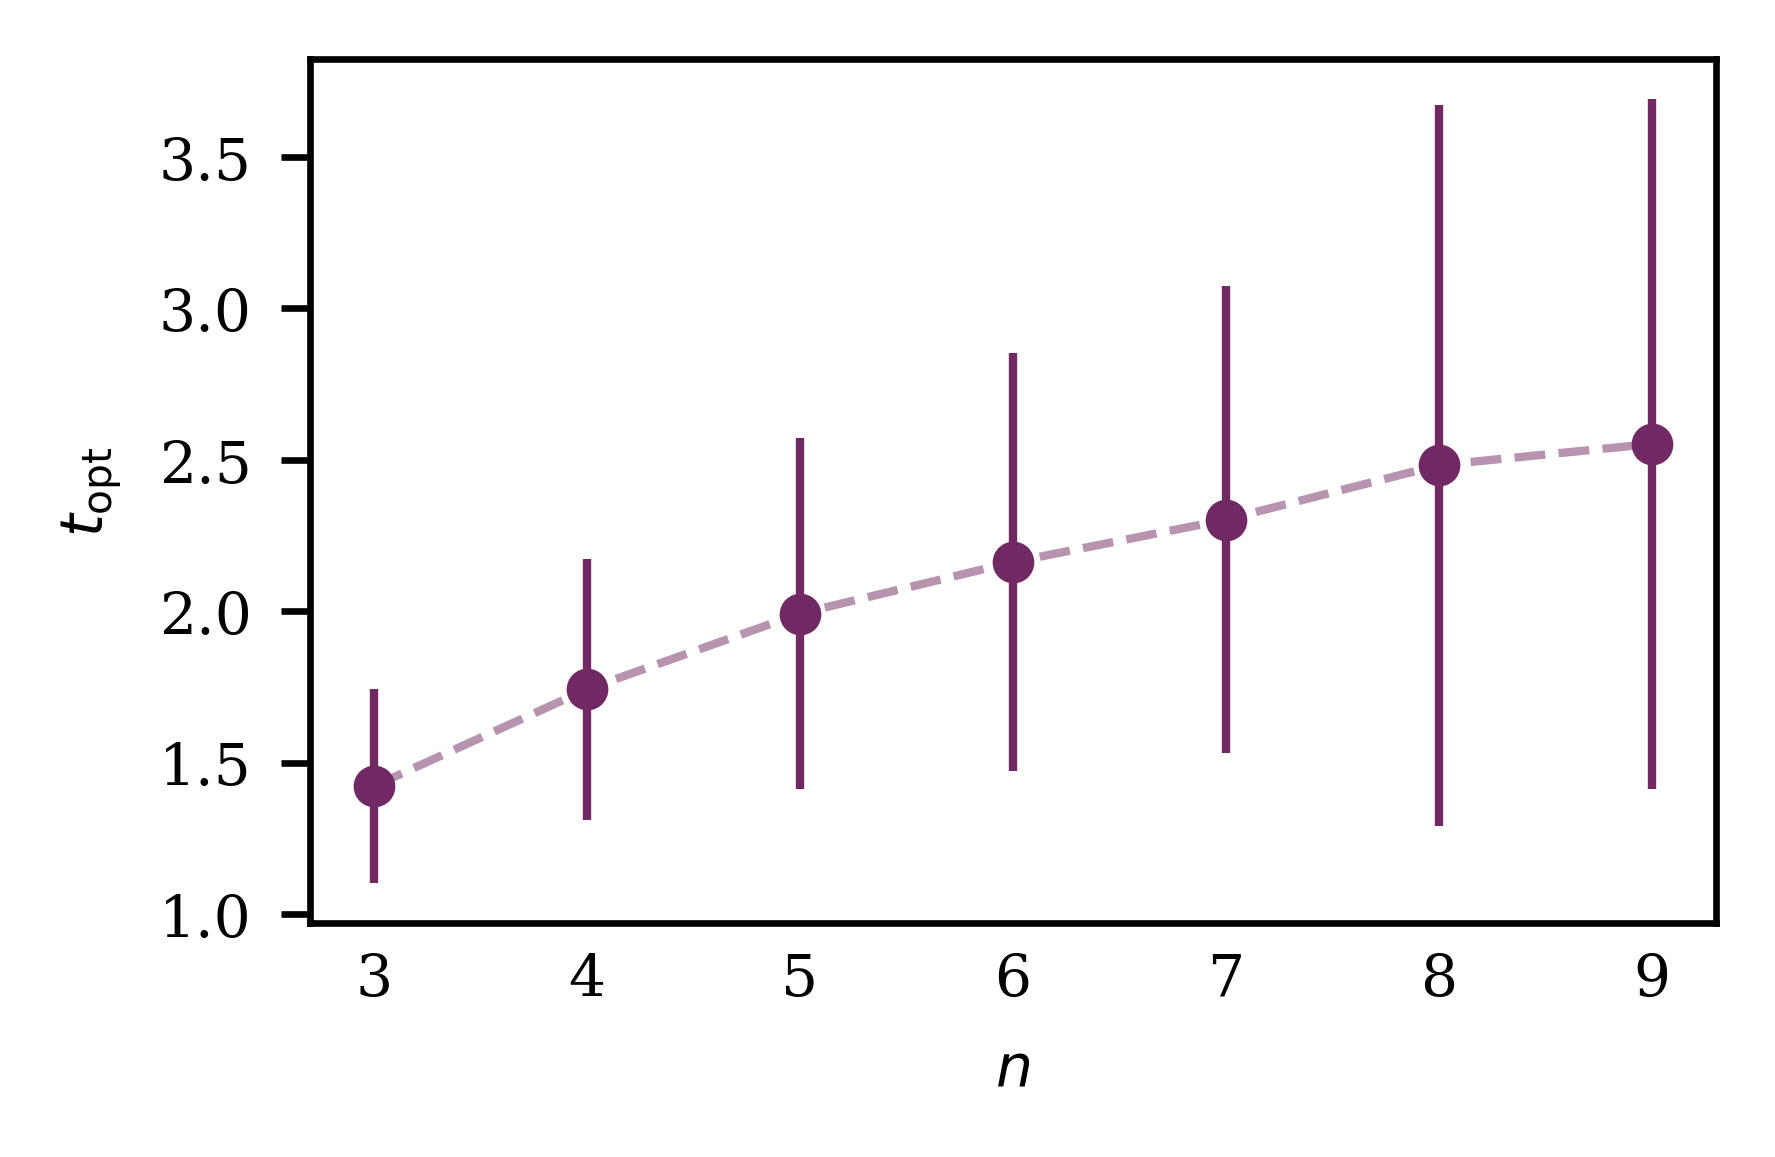

In [190]:
fig = plt.figure(figsize=(figure_size_x/2, figure_size_y/2))

plt.plot(qubits_range, t_opt_arr, '--', color=colors['purple'], alpha=0.5)
plt.errorbar(qubits_range, 
             t_opt_arr, 
             yerr=t_opt_err_arr, 
             fmt='o', 
             c=colors['purple'],
             ms=4)
plt.xlabel('$n$')
plt.ylabel('$t_{\mathrm{opt}}$')
plt.xticks(qubits_range)
plt.show()
fig.tight_layout()

fig.savefig(projectdir+f'figures/t_opt_vs_n')

## Combined panel

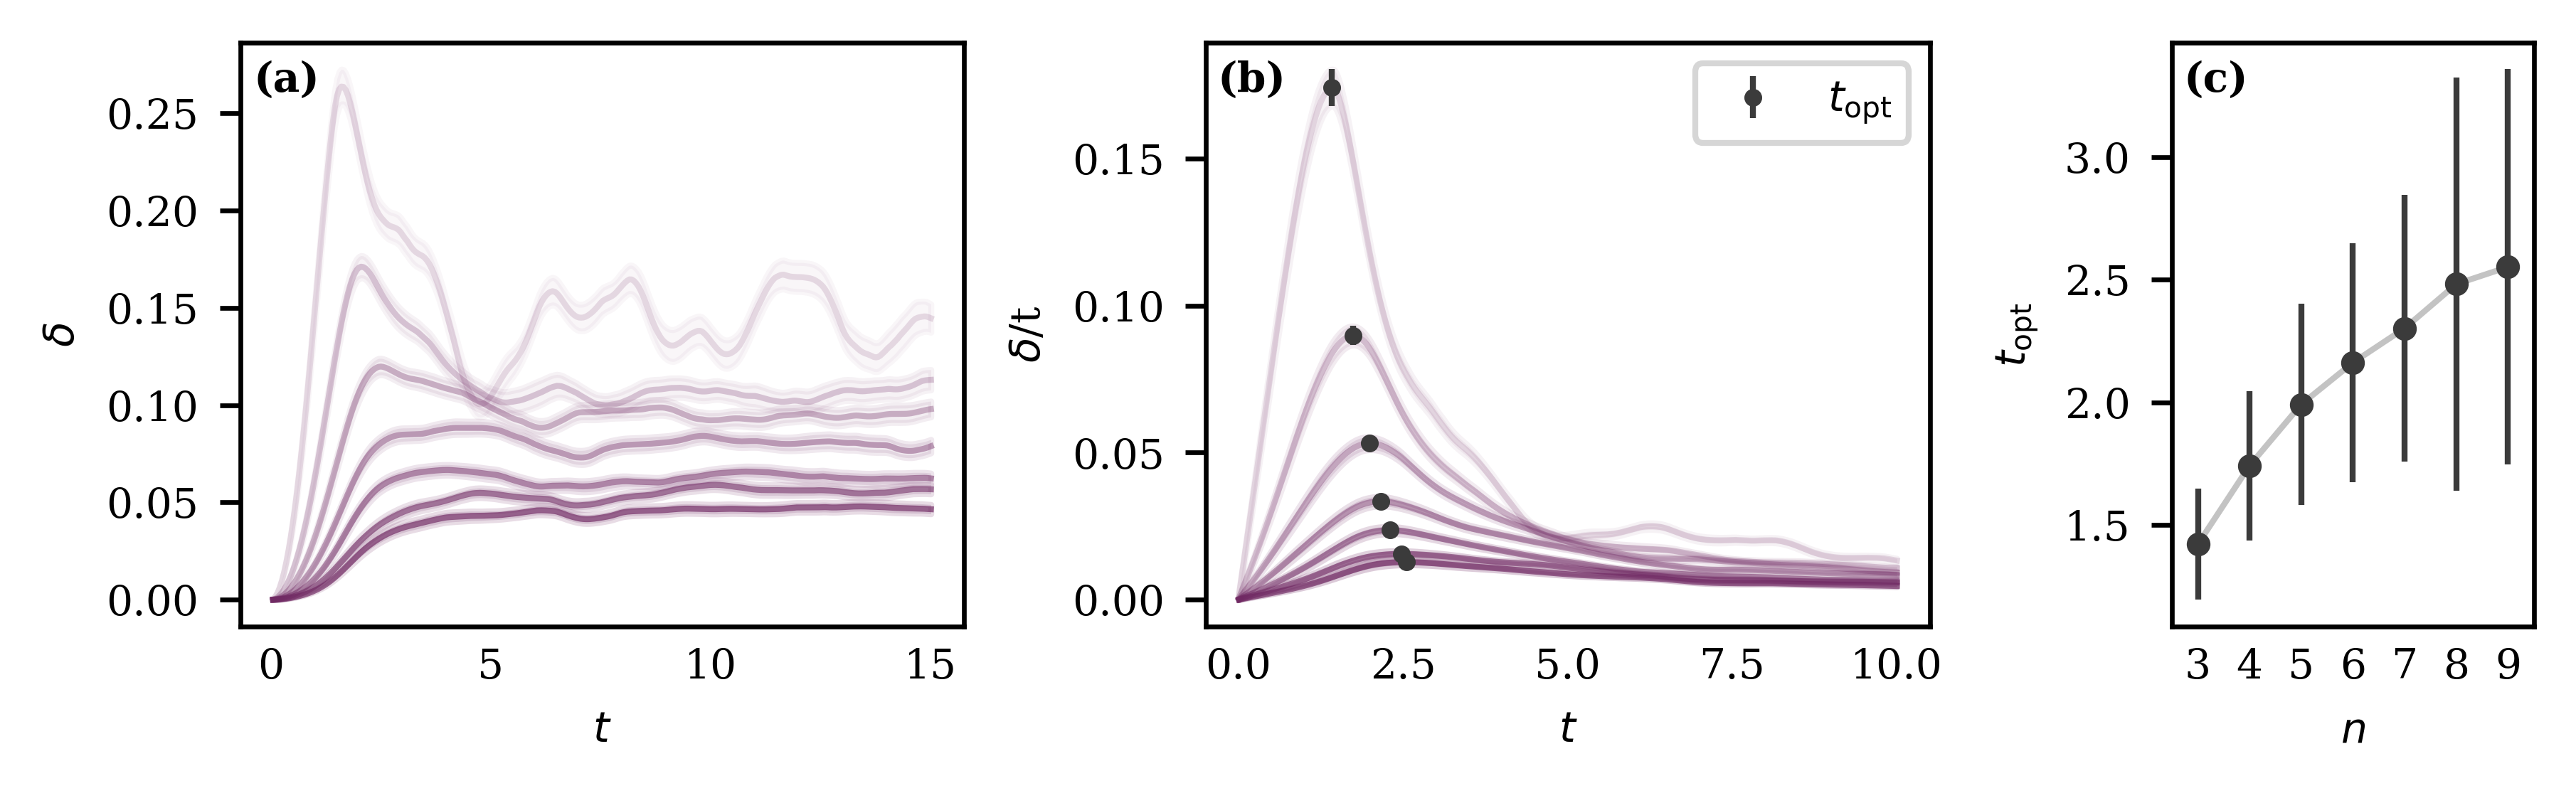

In [191]:
# Set up the 1x3 panel with shared width and height
fig, axes = plt.subplots(1, 3, figsize=(figure_size_x, figure_size_y/2), gridspec_kw={'width_ratios': [2,2,1]})

# First plot: Delta vs. time
for n_id, n in enumerate(qubits_range):
    axes[0].plot(time_range[:300], 
                 delta_quantum_arr_avg[n_id][:300],
                 color=colors['purple'],
                 label=f'n={n}',
                 alpha=(0.15 + 0.09 * n_id))
    axes[0].fill_between(time_range[:300], delta_quantum_arr_avg[n_id][:300]-delta_quantum_arr_std[n_id][:300], delta_quantum_arr_avg[n_id][:300]+delta_quantum_arr_std[n_id][:300], color=colors["purple"], alpha=(0.2 + 0.1*n_id)*0.2)

axes[0].set_xlabel('$t$')
axes[0].set_ylabel('$\delta$')
# axes[0].legend()  # Uncomment to show legend

# Add label (a)
axes[0].text(0.11, 0.97, '(a)', transform=axes[0].transAxes, fontsize=7, fontweight='bold', va='top', ha='right')

# Second plot: Delta over t vs. time with scatter plot
split = 100
for n_id, n in enumerate(qubits_range):
    axes[1].plot(time_range_short_times, 
                 delta_over_t_arr[n_id],
                 color=colors['purple'],
                 alpha=(0.15 + 0.09 * n_id))
    axes[1].fill_between(time_range_short_times, 
                        delta_over_t_arr[n_id]-delta_over_t_err_arr[n_id], 
                        delta_over_t_arr[n_id]+delta_over_t_err_arr[n_id],
                        color=colors["purple"],
                        alpha=(0.2 + 0.1*n_id)*0.3)
axes[1].errorbar(t_opt_arr, 
                 delta_over_t_opt_arr, 
                 delta_over_t_opt_err_arr,
                 fmt='o', 
                 color="#3b3b3b",
                 ms=2,
                 label='$t_{\mathrm{opt}}$')

axes[1].set_xlabel('$t$')
axes[1].set_ylabel('$\delta$/t')
axes[1].legend()

# Add label (a)
axes[1].text(0.11, 0.97, '(b)', transform=axes[1].transAxes, fontsize=7, fontweight='bold', va='top', ha='right')

# Third plot: t_opt vs. qubit range with error bars
axes[2].plot(qubits_range, t_opt_arr, '-', color="#3b3b3b", alpha=0.3)
axes[2].errorbar(qubits_range, 
                 t_opt_arr, 
                 yerr=t_opt_err_arr/np.sqrt(2), 
                 fmt='o', 
                 c="#3b3b3b",
                 ms=3)
axes[2].set_xlabel('$n$')
axes[2].set_ylabel('$t_{\mathrm{opt}}$')
axes[2].set_xticks(qubits_range)
axes[2].set_xlim(2.5, 9.5)

# Add label (a)
axes[2].text(0.21, 0.97, '(c)', transform=axes[2].transAxes, fontsize=7, fontweight='bold', va='top', ha='right')

# axes[2].set_xscale('log')

# Adjust layout to avoid overlapping
fig.tight_layout()

# Save the combined figure
fig.savefig(projectdir + 'figures/panel_delta_vs_t')
fig.savefig(projectdir + 'figures/pdf_figures/panel_delta_vs_t.pdf')

plt.show()

In [192]:
# Save optimal gammas
optimal_times = {}
for n_id, n in enumerate(range(3,10)):
    optimal_times[f'{n}'] = np.round(t_opt_arr[n_id], 7)

save_in_json(optimal_times, 'optimal_times.json')

In [193]:
stds

array([0.00679585, 0.00427206, 0.00323337, 0.00232576, 0.00197865,
       0.00148705, 0.00126157])

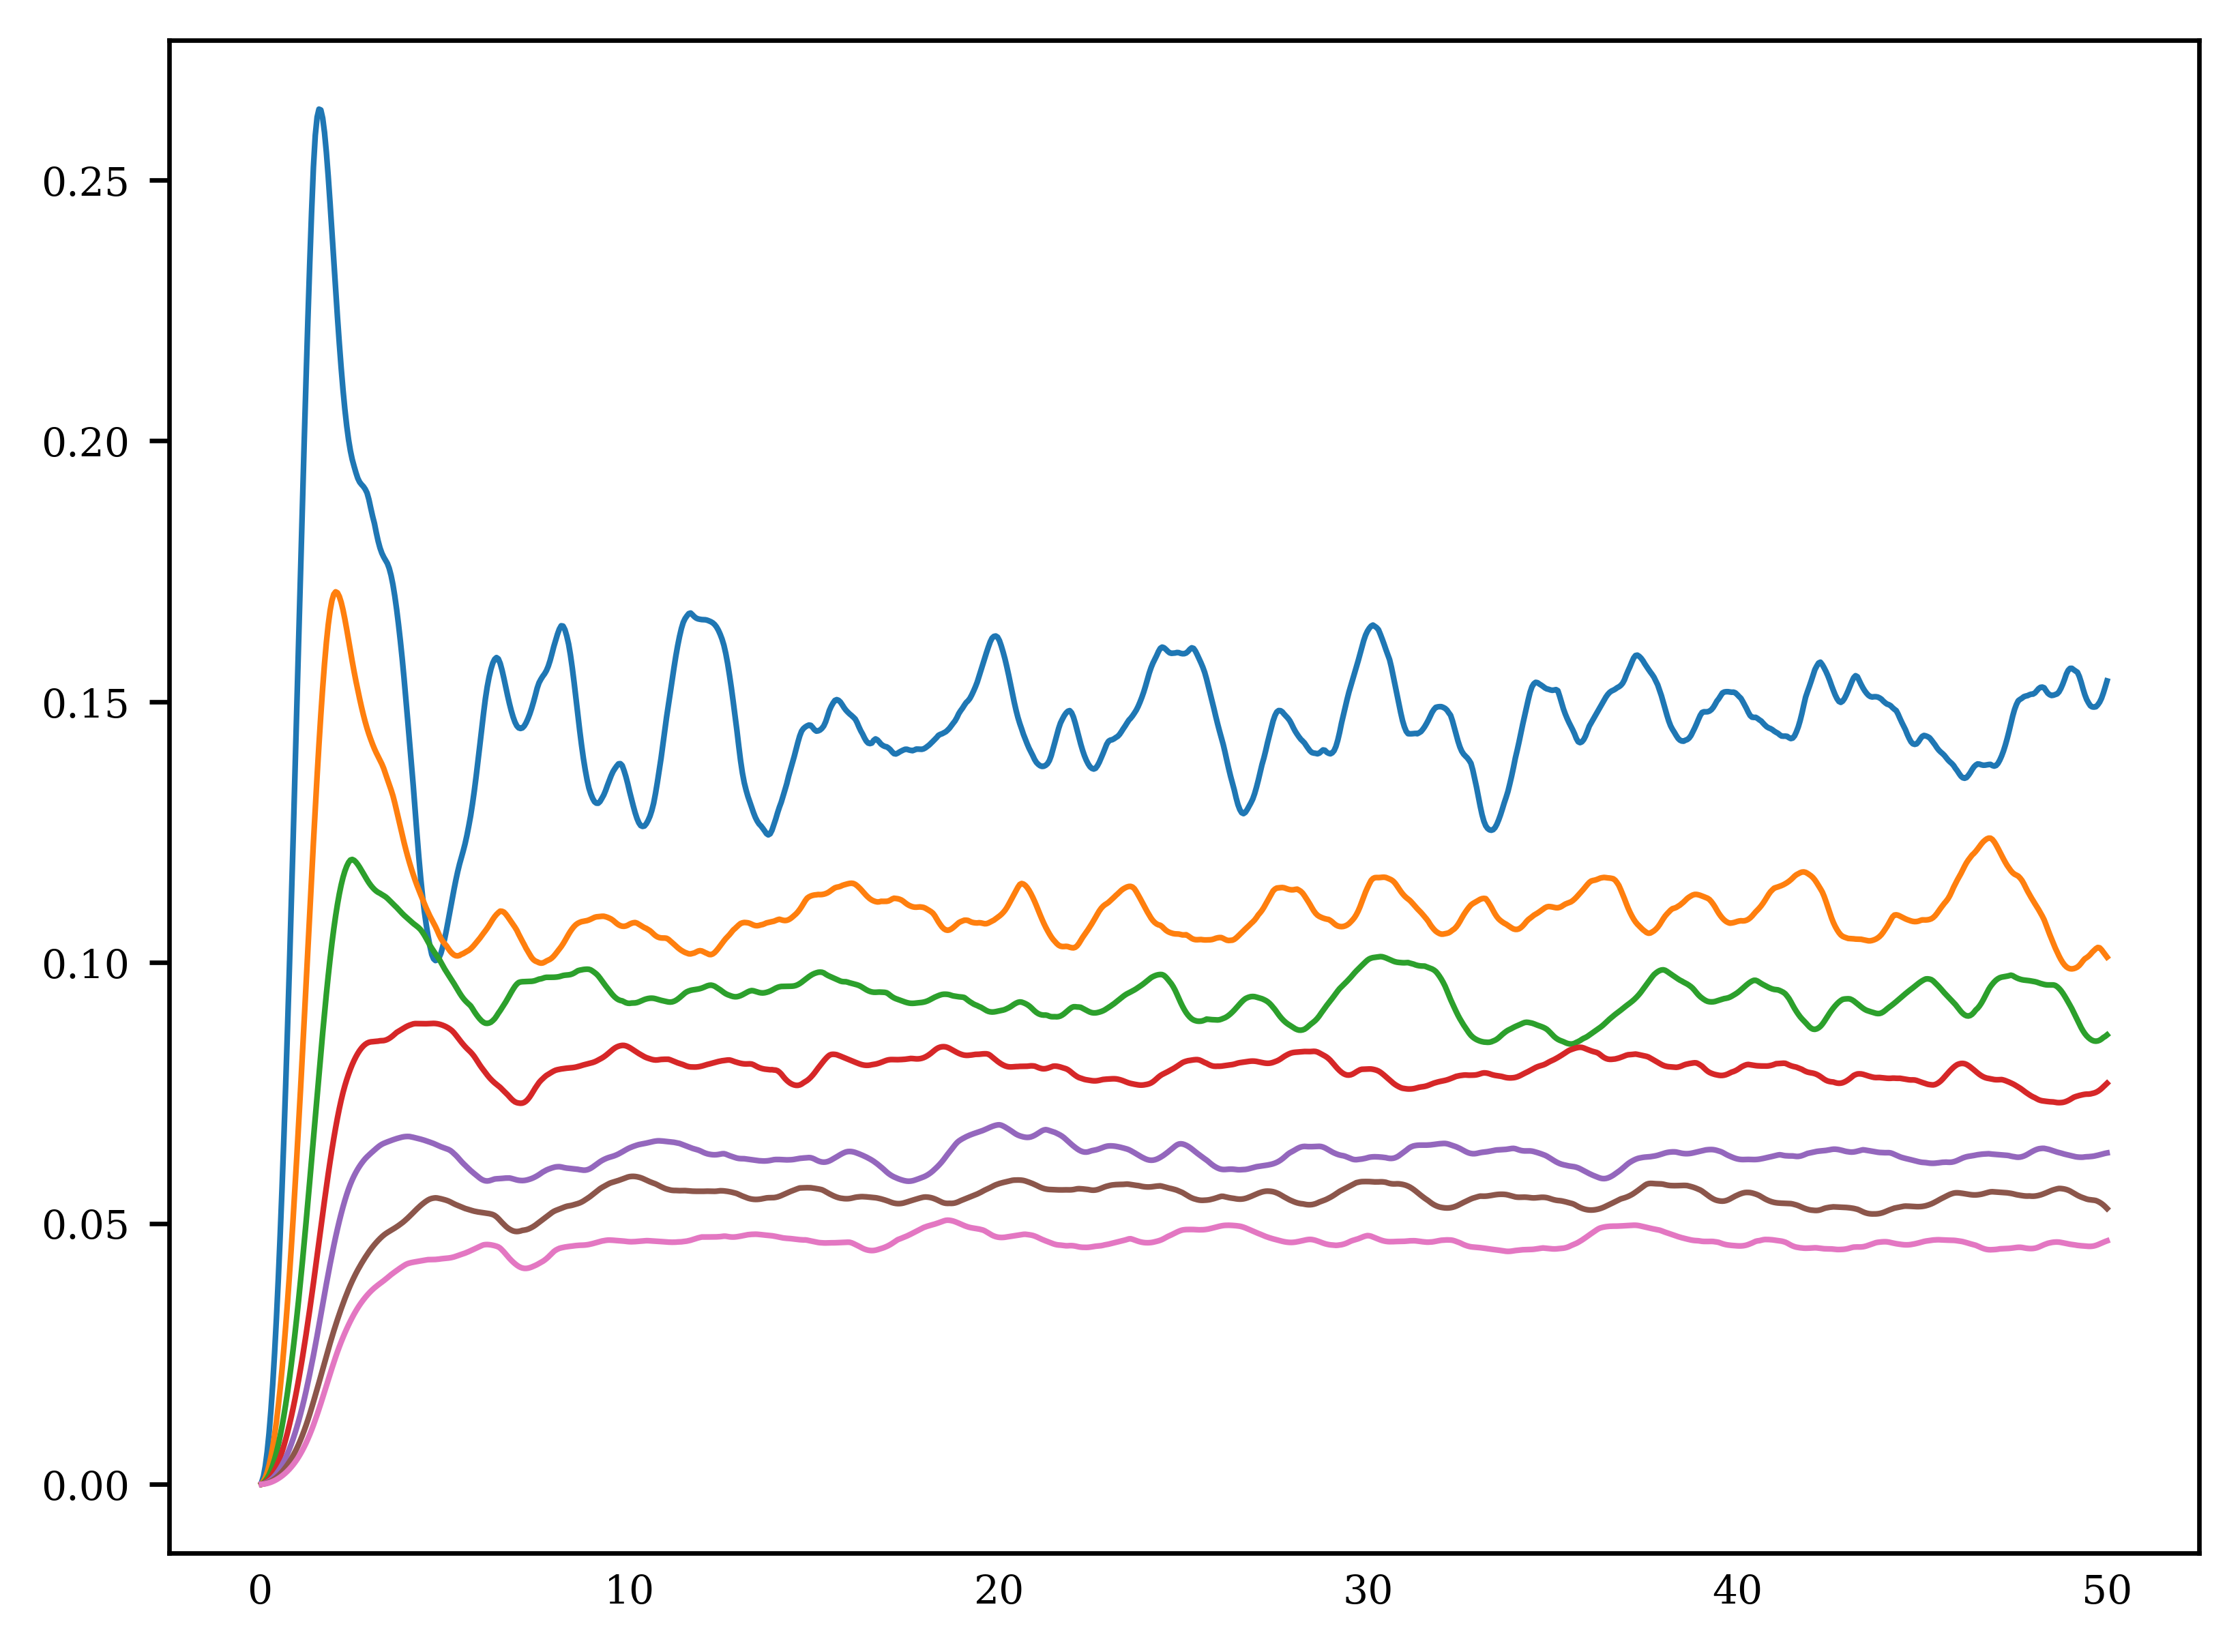

In [202]:
for n_id, n in enumerate(qubits_range[:]):
    plt.plot(time_range, delta_quantum_arr_avg[n_id])
    # plt.fill_between(time_range, delta_quantum_arr_avg[n_id]-5*stds[n_id], delta_quantum_arr_avg[n_id]+5*stds[n_id])

In [195]:
means

array([0.14904182, 0.10955148, 0.0916154 , 0.07875818, 0.06194095,
       0.05485751, 0.04671603])

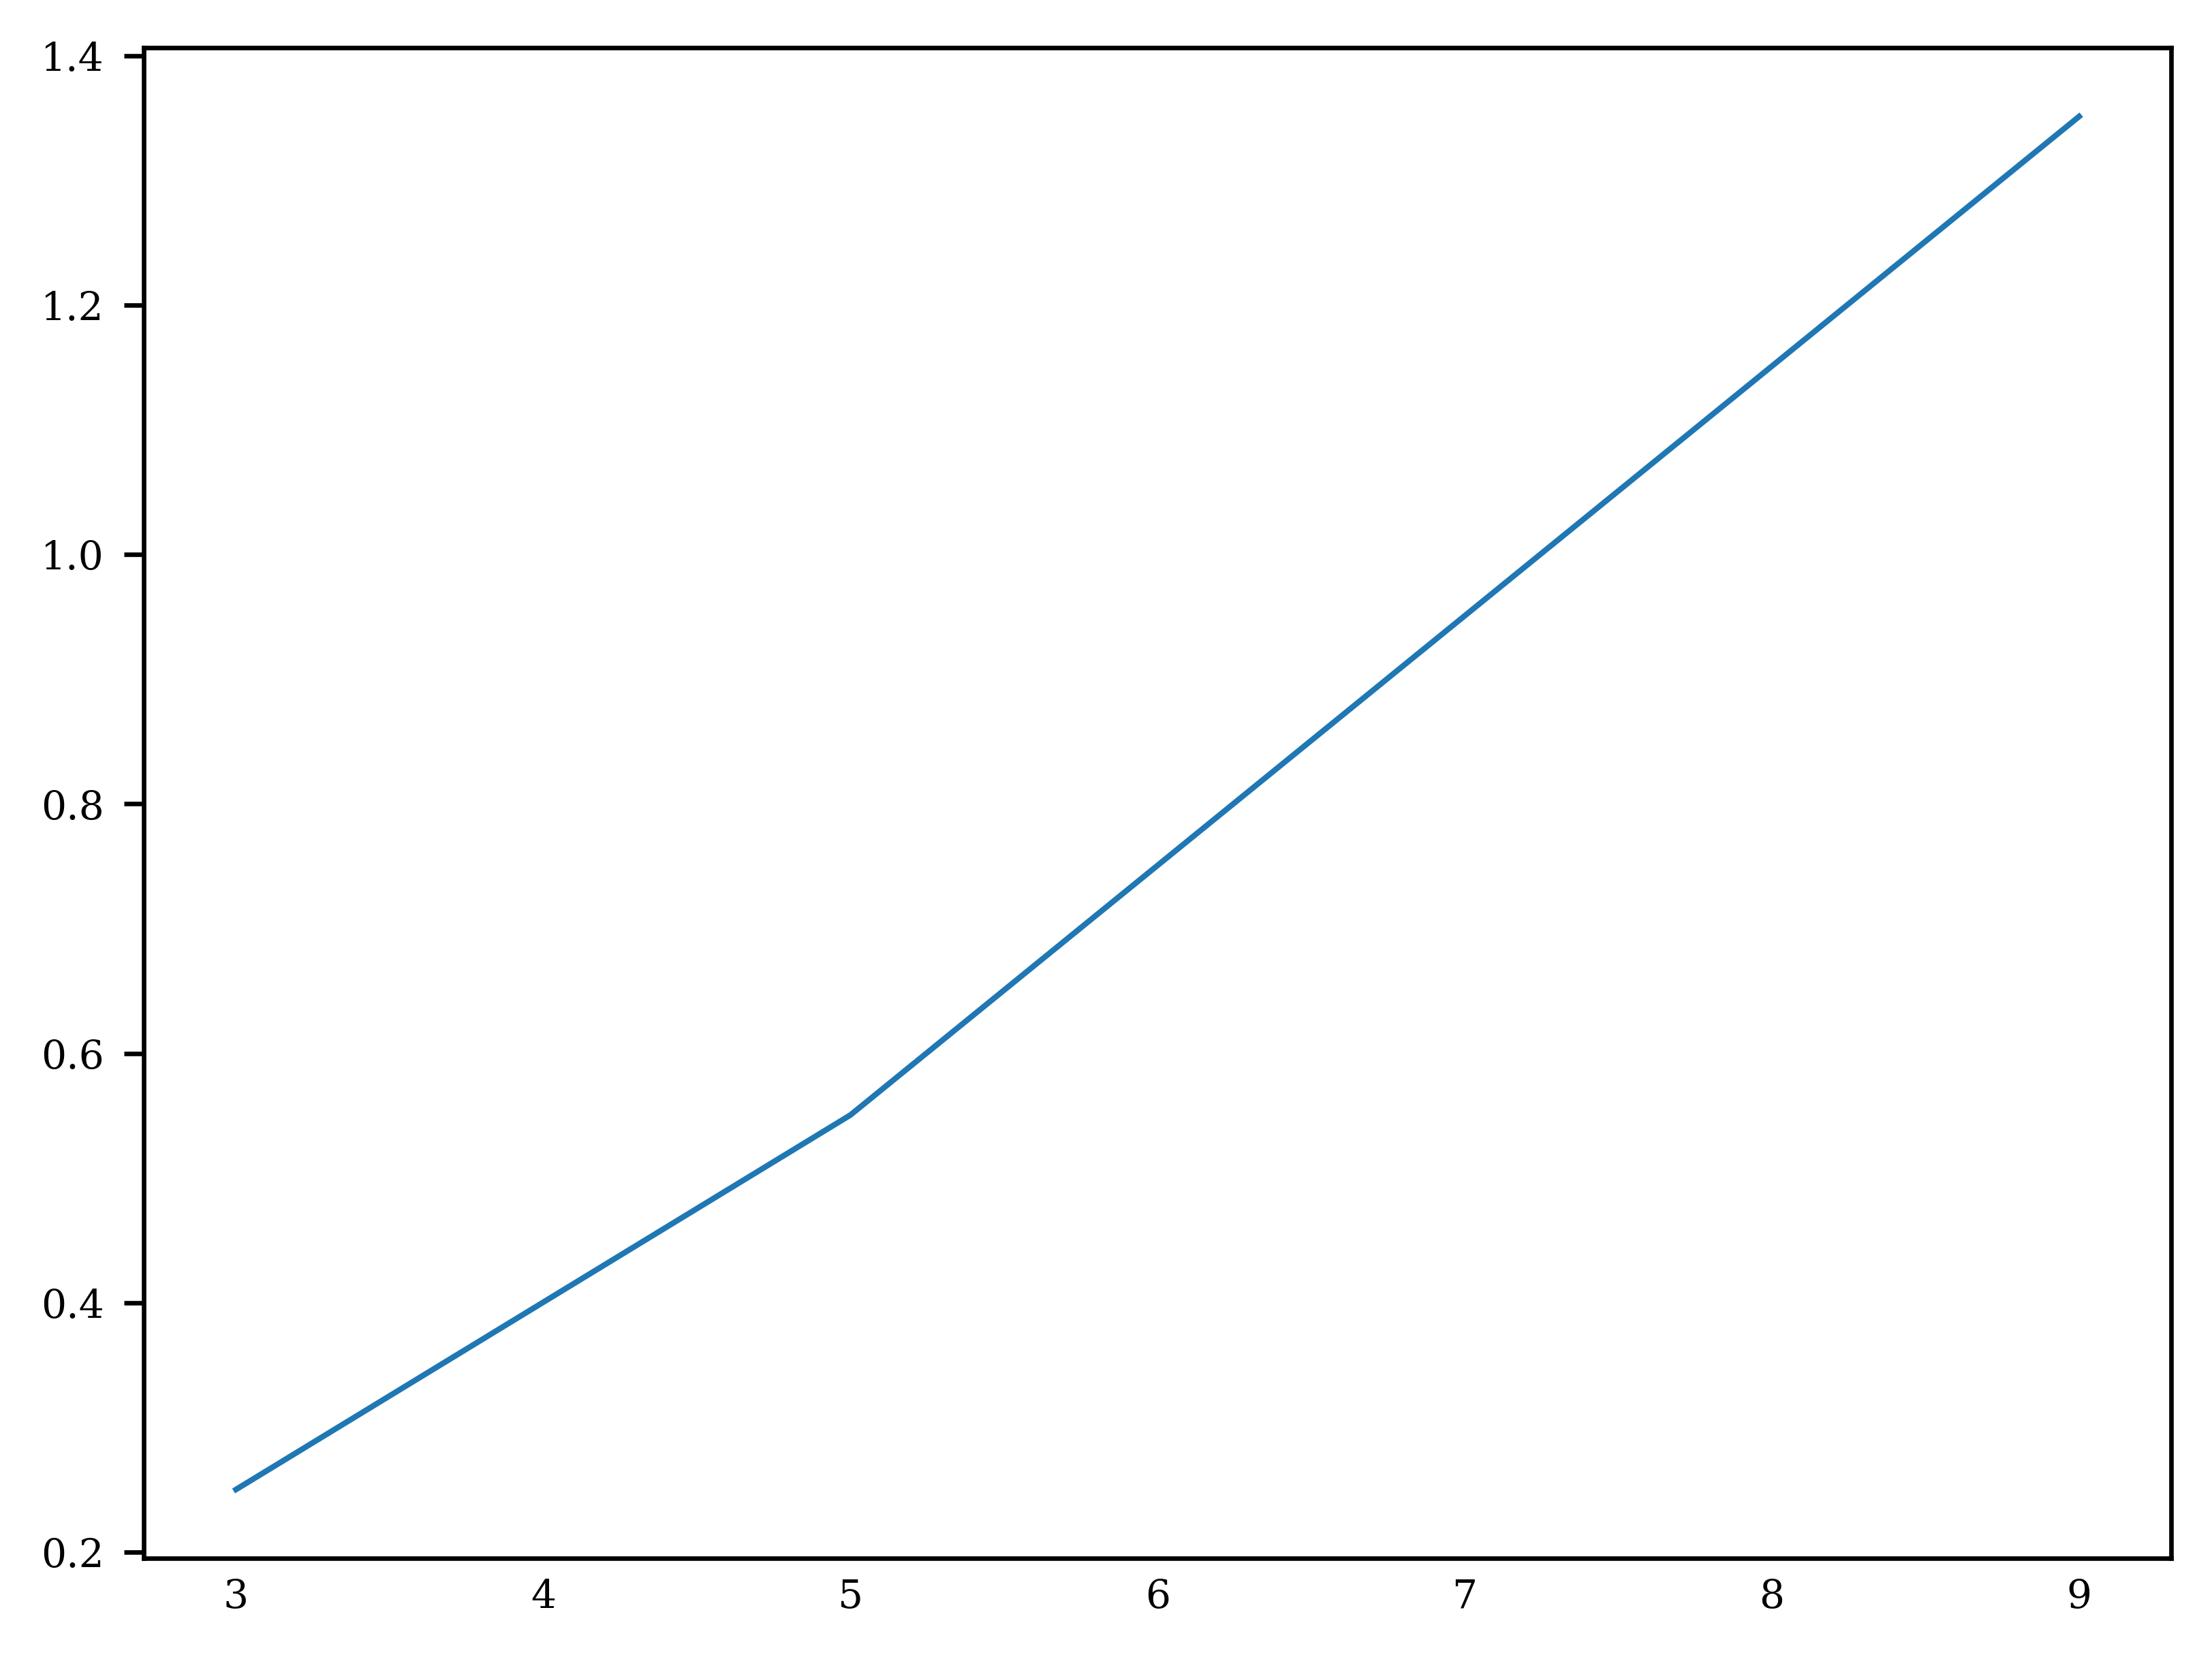

In [211]:
def find_first_hit(data, val=0.01, epsilon=1e-3):
    """
    Find the first time index where the curve gets epsilon-close to the mean.

    Parameters:
        data (np.ndarray): Array of temporal data, f(t).
        val (float): Value to hit.
        epsilon (float): Threshold for being close to the mean.

    Returns:
        int: Index of the first point where the curve is epsilon-close to the given value.
    """
    for i, value in enumerate(data):
        if np.abs(value - val) <= epsilon:
            return i  # Return the first index where the condition is met
    return -1  # Return -1 if no such point is found

first_hits = []  # To store the first mean-hit indices

for n_id, n in enumerate(qubits_range):
    first_hit = find_first_hit(delta_quantum_arr_avg[n_id])
    first_hits.append(first_hit)

# Convert indices to time values (if needed):
first_hit_times = [time_range[hit] if hit != -1 else np.nan for hit in first_hits]

plt.plot(qubits_range, first_hit_times)

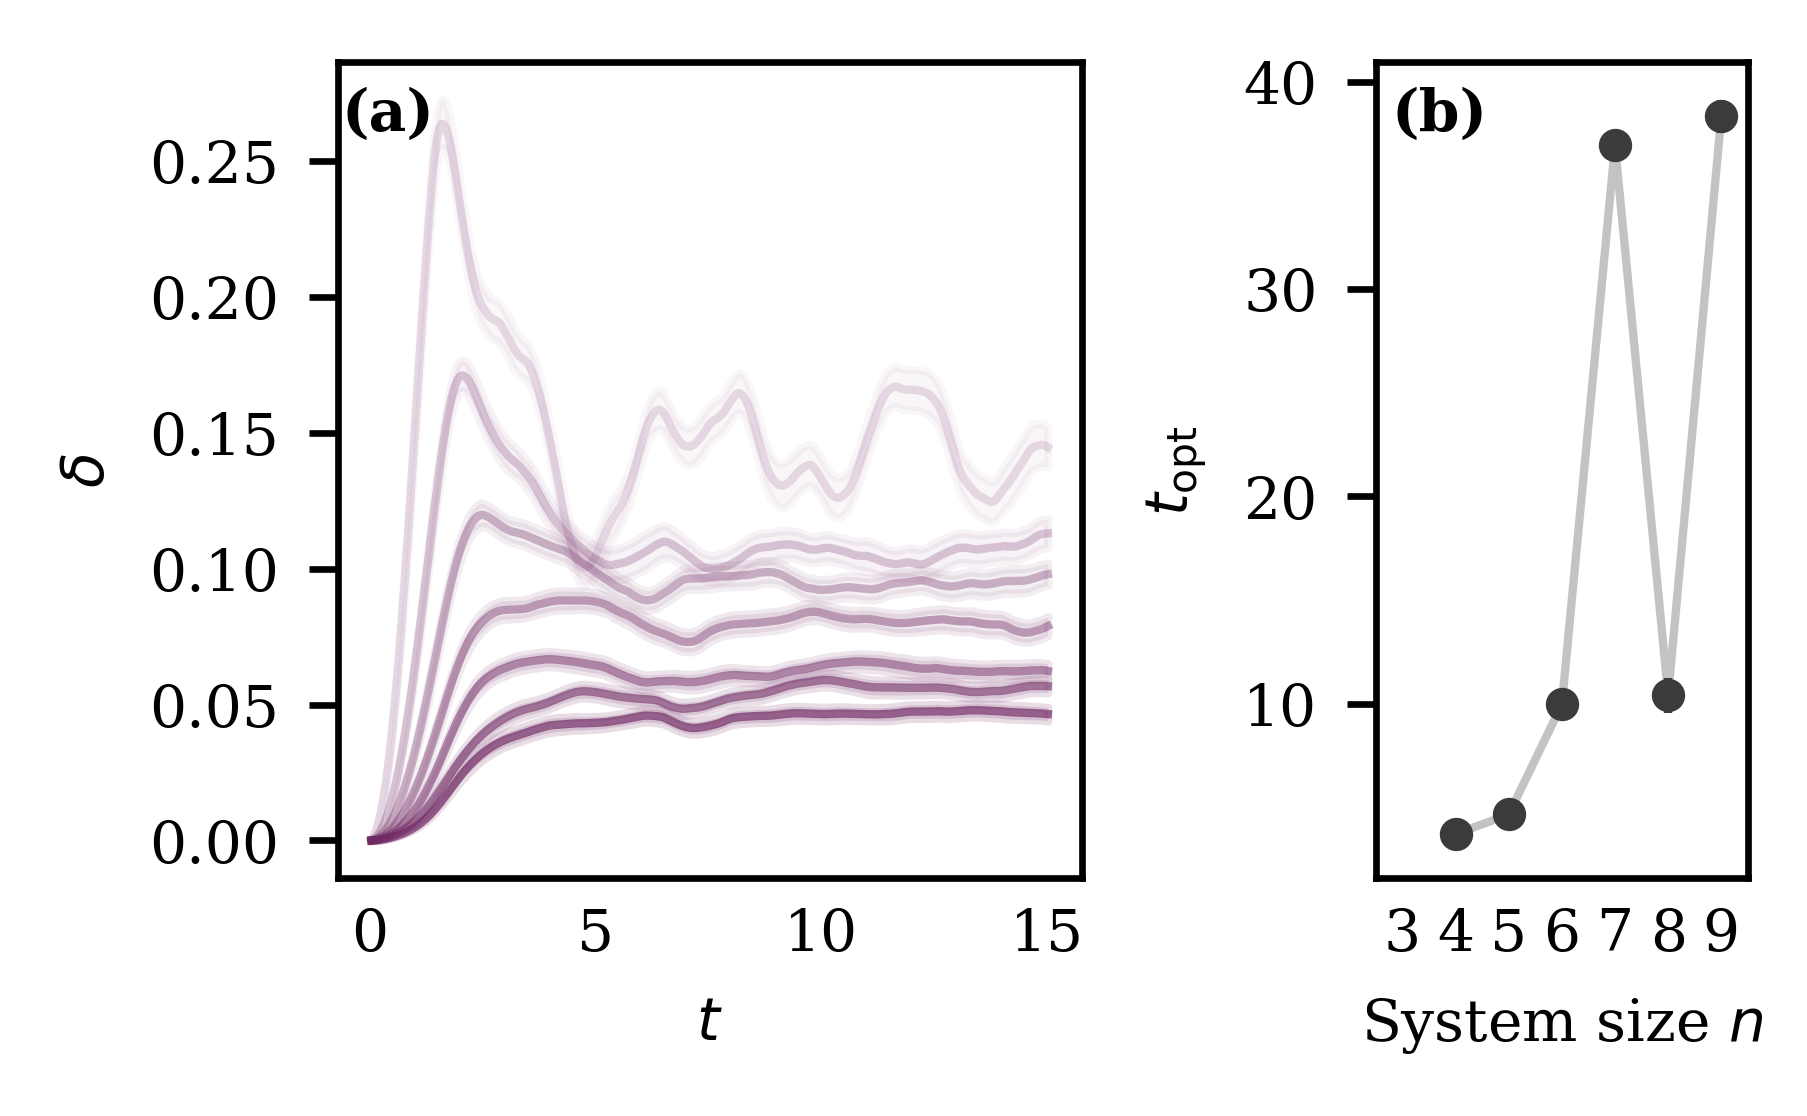

In [197]:
end = 300

# Create a 1x2 panel with a 2:1 width ratio
fig, axes = plt.subplots(1, 2, figsize=(figure_size_x / 2, figure_size_y / 2), gridspec_kw={'width_ratios': [2, 1]})

# First plot: Delta vs. time
for n_id, n in enumerate(qubits_range):
    axes[0].plot(time_range[:end], 
                 delta_quantum_arr_avg[n_id][:end],
                 color=colors['purple'],
                 label=f'n={n}',
                 alpha=(0.15 + 0.09 * n_id))
    axes[0].fill_between(time_range[:end], 
                         delta_quantum_arr_avg[n_id][:end] - delta_quantum_arr_std[n_id][:end], 
                         delta_quantum_arr_avg[n_id][:end] + delta_quantum_arr_std[n_id][:end], 
                         color=colors["purple"], 
                         alpha=(0.2 + 0.1 * n_id) * 0.2)

axes[0].set_xlabel('$t$')
axes[0].set_ylabel('$\delta$')
# axes[0].legend()  # Uncomment to show legend if needed

# Add label (a)
axes[0].text(0.13, 0.97, '(a)', transform=axes[0].transAxes, fontsize=7, fontweight='bold', va='top', ha='right')

# Second plot: Delta over t vs. time with scatter plot
axes[1].plot(qubits_range[1:], convergence_times[1:], '-', color="#3b3b3b", alpha=0.3)
axes[1].errorbar(qubits_range[1:], 
                 convergence_times[1:], 
                 yerr=t_opt_err_arr[1:]/np.sqrt(2), 
                 fmt='o', 
                 c="#3b3b3b",
                 ms=3)
axes[1].set_xlabel('System size $n$')
axes[1].set_ylabel('$t_{\mathrm{opt}}$')
axes[1].set_xticks(qubits_range)
axes[1].set_xlim(2.5, 9.5)

# Add label (b)
axes[1].text(0.30, 0.97, '(b)', transform=axes[1].transAxes, fontsize=7, fontweight='bold', va='top', ha='right')

# Adjust layout to avoid overlapping and save the figure
fig.tight_layout()
fig.savefig(projectdir + 'figures/combined_delta_vs_t_and_delta_over_t')
fig.savefig(projectdir + 'figures/pdf_figures/combined_delta_vs_t_and_delta_over_t.pdf')

plt.show()

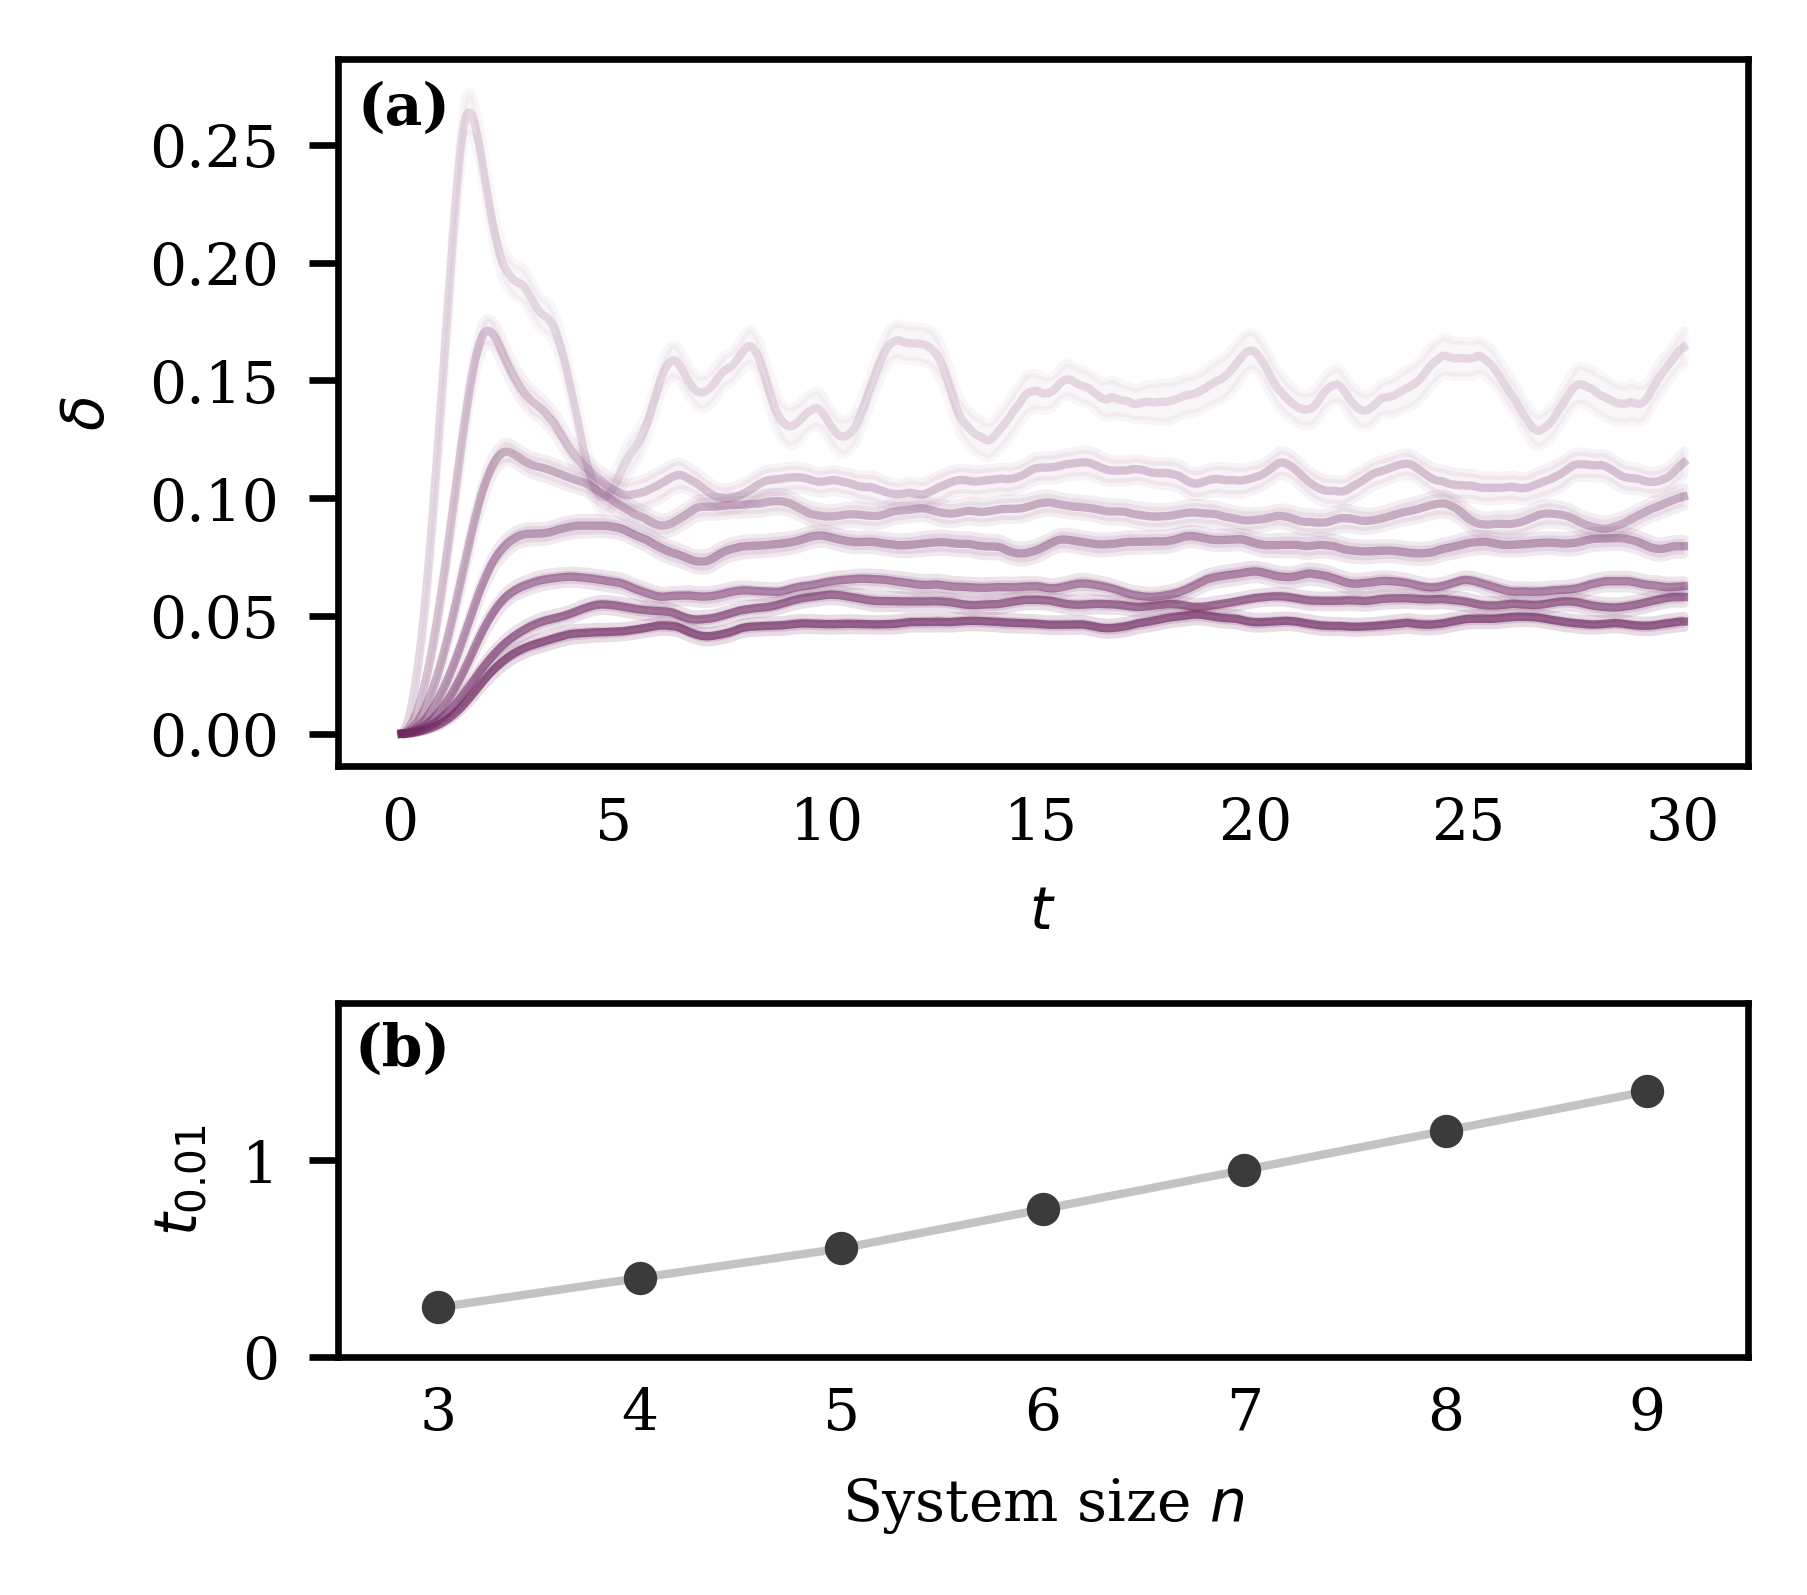

In [223]:
# Create a 2x1 panel for vertical arrangement
fig, axes = plt.subplots(2, 1, figsize=(figure_size_x / 2, figure_size_y / 1.4), gridspec_kw={'height_ratios': [2, 1]})

end = 600 

# First plot: Delta vs. time
for n_id, n in enumerate(qubits_range):
    axes[0].plot(time_range[:end], 
                 delta_quantum_arr_avg[n_id][:end],
                 color=colors['purple'],
                 label=f'n={n}',
                 alpha=(0.15 + 0.09 * n_id))
    axes[0].fill_between(time_range[:end], 
                         delta_quantum_arr_avg[n_id][:end] - delta_quantum_arr_std[n_id][:end], 
                         delta_quantum_arr_avg[n_id][:end] + delta_quantum_arr_std[n_id][:end], 
                         color=colors["purple"], 
                         alpha=(0.2 + 0.1 * n_id) * 0.2)

axes[0].set_xlabel('$t$')
axes[0].set_ylabel('$\delta$')

# Add label (a)
axes[0].text(0.08, 0.97, '(a)', transform=axes[0].transAxes, fontsize=7, fontweight='bold', va='top', ha='right')

# Second plot: Delta over t vs. time with scatter plot
axes[1].plot(qubits_range, first_hit_times, '-', color="#3b3b3b", alpha=0.3)
axes[1].errorbar(qubits_range, 
                 first_hit_times, 
                 yerr=time_range[1] - time_range[0], 
                 fmt='o', 
                 c="#3b3b3b",
                 ms=3)
axes[1].set_xlabel('System size $n$')
axes[1].set_ylabel('$t_{\mathrm{0.01}}$')
axes[1].set_xticks(qubits_range[:])
axes[1].set_xlim(2.5, 9.5)
axes[1].set_ylim(0, 1.8)

# Add label (b)
axes[1].text(0.08, 0.95, '(b)', transform=axes[1].transAxes, fontsize=7, fontweight='bold', va='top', ha='right')

# Adjust layout to avoid overlapping and save the figure
fig.tight_layout()
fig.savefig(projectdir + 'figures/delta_vs_t')
fig.savefig(projectdir + 'figures/pdf_figures/delta_vs_t.pdf')

plt.show()
